In [3]:
import sqlite3
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import itertools as it

#print(mp.__version__)

%matplotlib inline

In [4]:
def select_by(db, name, type):

    S = """select s1.ts,s1.type,s1.tid,s1.iter,(s2.ts-s1.ts),s1.heap,s2.heap,s1.details
  from stats s1 inner join stats s2 on s1.tid=s2.tid and s1.iter=s2.iter and s1.action!=s2.action and s1.type=s2.type
 where s1.type='{type}' and s1.action='start' and s1.name = '{name}' and s2.name = '{name}'
 order by s1.ts asc;"""
    cur = db.cursor()
    r = []
    #print S.format(type=type, name=name)
    for row in cur.execute(S.format(type=type, name=name)):
        r.append(row)
    return r

def csv(a, N=-1):
    n = 0
    for i in a:
        print ",".join(str(x) for x in i)
        if N > 0:
            if n < N:
                n += 1
            else:
                break


In [5]:
def load_data_set(name):
    db = sqlite3.connect("stats.sql")
    DS = ''
    a = select_by(db, name, 'compute')
    b = select_by(db, name, 'gc')
    #c = a + b
    #c.sort(key=lambda a: a[0])
    #csv(c)
    db.close()
    return a,b


In [16]:
def gen_graph(name='20170430-hask-p9', W=100, B=30, 
              FS=18, DISCARD=0,
              HEAP=True, CTLOG=True, HEAPLOG=True,
              CTLO=(0,0), HEAPLO=(0,0),
              CTLABEL=True, HEAPLABEL=True,
              XDIV=10^3, YDIV=10^3):
    """
    DISCARD = discard this many data points from the start of the
         dataset. initial datapoints likely to be contain skew as
         OS process initializes (e.g. JIT) and stablizes
    W = width of graph (number of data points to include)
    B = cut off when GC thread kicks in (usually around the 30th data point
        but you should inspect the "raw" file and count the number of "comp:start"
        entries until you see the first "gc:start" and use that count as B.)
    FS = font size for axis labels/title
    HEAP = T|F show heap line on chart
    CTLOG = T|F apply log scale to compute thread line
    HEAPLOG = T|F apply log scale to heap line
    CTLO = (δx,δy) tuple allowing for adjustment of compute stats (mu/sigma label)
    HEAPLO = (δx, δy) tuple allow for adjustment of heap stats (mu/sigma label)
    """
    a, b = load_data_set(name)

    xs = [(x[0]-a[0][0])/(XDIV) for x in a]
    ys = [x[4]/(YDIV) for x in a]
    heapys = [(x[5]/(1024*1024)) for x in a]

    #for i, v in enumerate(ys[:W]):
    #    print i, v

    W_ = W - B + DISCARD
    mean0, mean1 = np.mean(ys[DISCARD:B]), np.mean(ys[DISCARD+B:W_])
    std0, std1 = np.std(ys[DISCARD:B]), np.std(ys[DISCARD+B:W_])
    #print mean0, std0
    #print mean1, std1
    #print xs[:10]

    L0 = "RT/-MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean0, std0)
    L1 = "RT/+MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean1, std1)

    fig, ax1 = plt.subplots(dpi=120, figsize=(7,7))
    ax2 = ax1.twinx()
    ax1.plot(xs[DISCARD:W], ys[DISCARD:W], 'bo', markerfacecolor='none')
    if CTLOG is True:
        ax1.set_yscale('log')
    if HEAP is True:
        ax2.plot(xs[DISCARD:W], heapys[DISCARD:W], 'r-', alpha=0.3)
    if HEAPLOG is True:
        ax2.set_yscale('log')

    ax1.set_xlabel(r"Delta Interation Start Time ($sec$)", fontsize=FS)
    ax1.set_ylabel("Run Time ($ms$)", color='blue', fontsize=FS)
    ax2.set_ylabel("Heap Used ($Mbytes$)", color='red', fontsize=FS)
    #plt.plot(xs[:W], ys[:W], 'bs')
    try:
        # *XDIV doesnt do what I expected so I left it out for now
        if CTLABEL:
            ax1.text(0.0 + CTLO[0]*XDIV, mean0*2 + CTLO[1], L0)
        if HEAPLABEL:
            ax1.text(xs[50] + HEAPLO[0]*XDIV, mean1 + HEAPLO[1], L1)
    except Exception as e:
        print "Failed to place mu/sigma text: ", e

    ax1.set_title(a[0][7], fontsize=FS)

    xs_ = np.array(xs)
    ys_ = np.array(ys)
    heapys_ = np.array(heapys)
    #print name
    #print "xs_ ", np.shape(xs_), np.min(xs_), np.max(xs_)
    #print "ys_ ", np.shape(ys_), np.min(ys_), np.max(ys_)
    #print "hp  ", np.shape(heapys_), np.min(heapys_), np.max(heapys_)
    #print "xs_30 ", xs_[B-1]
    
    sub = fig.gca()
    sub.add_patch(
        patches.Rectangle(
            (np.min(xs_), np.min(heapys_)), #(-1e6, 0),      # (x,y)
            xs_[B],                         # 1e6 + 3*10**6, # width
            np.max(heapys_),                # 700            # height
            alpha=0.1, facecolor="#555555"
        )
    )
    sub.add_patch(
        patches.Rectangle(
            (xs_[B], np.min(heapys_)), # (3*10**6, 00), # (x,y)
            np.max(xs_), # 1.2*10**7,     # width
            np.max(heapys_), #6000,          # height
            alpha=0.1, facecolor="#AAAAAA"
        )
    )
    
    pp = PdfPages("{}.pdf".format(name))
    pp.savefig(fig)
    pp.close()

scala-37-SerialGC.txt
xs_  (250,) 0.0 325100.0
ys_  (250,) 300.0 308.0
hp   (250,) 5 271
xs_30  15672.0
scala-38-SerialGC.txt
xs_  (250,) 0.0 371820.0
ys_  (250,) 485.0 504.0
hp   (250,) 7 269
xs_30  17939.0
scala-39-SerialGC.txt
xs_  (250,) 0.0 448935.0
ys_  (250,) 786.0 895.0
hp   (250,) 7 276
xs_30  21559.0
scala-40-SerialGC.txt
xs_  (250,) 0.0 576697.0
ys_  (250,) 1235.0 1708.0
hp   (250,) 10 271
xs_30  27465.0


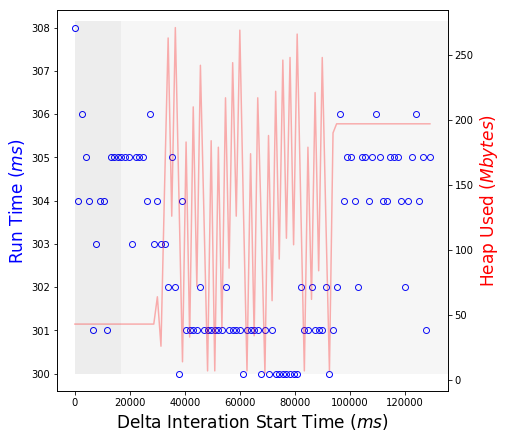

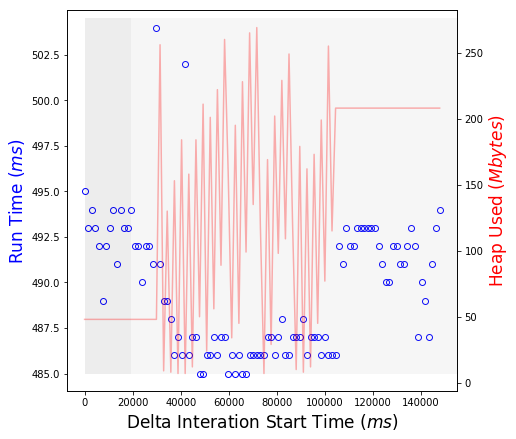

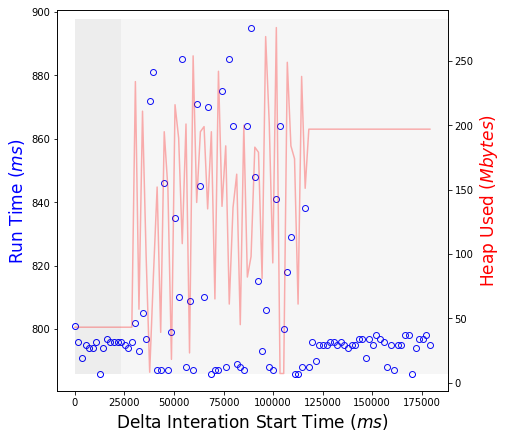

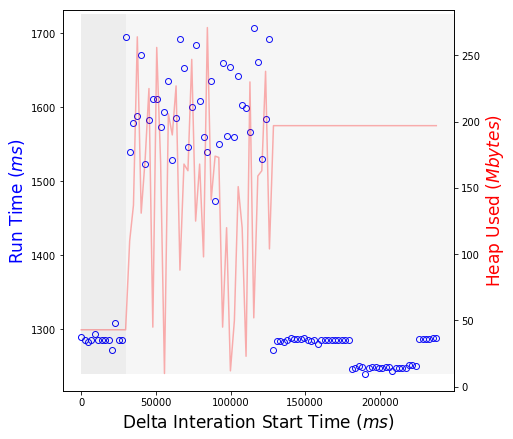

In [8]:
gen_graph(name='scala-37-SerialGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-38-SerialGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-39-SerialGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-40-SerialGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))

clojure-1600
xs_  (500,) 0.0 100318.888889
ys_  (500,) 31.6666666667 599.777777778
hp   (500,) 2865 6719
xs_30  3430.77777778
clojure-1800
xs_  (500,) 0.0 106400.888889
ys_  (500,) 39.7777777778 535.333333333
hp   (500,) 2866 6863
xs_30  3776.88888889
clojure-1900
xs_  (500,) 0.0 118151.777778
ys_  (500,) 44.6666666667 595.777777778
hp   (500,) 2928 6899
xs_30  3802.0
clojure-2000
xs_  (500,) 0.0 123733.888889
ys_  (500,) 49.2222222222 618.555555556
hp   (500,) 2867 6774
xs_30  4545.11111111
clojure-2100
xs_  (500,) 0.0 132360.111111
ys_  (500,) 55.2222222222 563.111111111
hp   (500,) 2965 6473
xs_30  4231.77777778
clojure-2200
xs_  (500,) 0.0 138561.222222
ys_  (500,) 60.5555555556 570.888888889
hp   (500,) 2887 6129
xs_30  4790.44444444
clojure-2300
xs_  (500,) 0.0 145325.111111
ys_  (500,) 65.7777777778 573.777777778
hp   (500,) 2959 6459
xs_30  5030.22222222


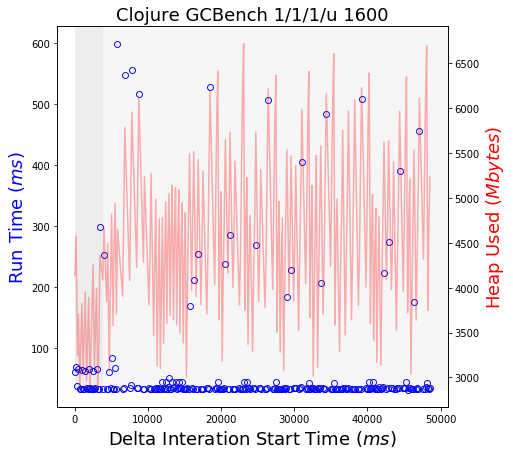

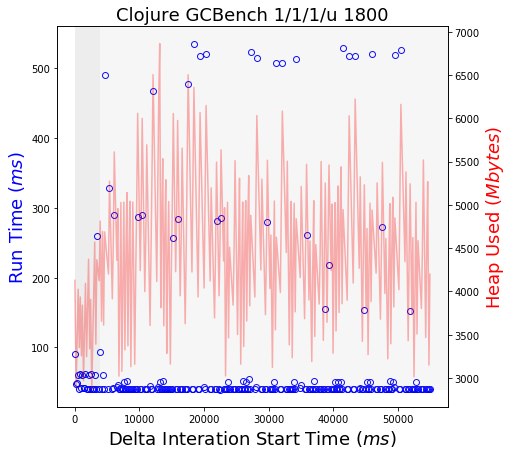

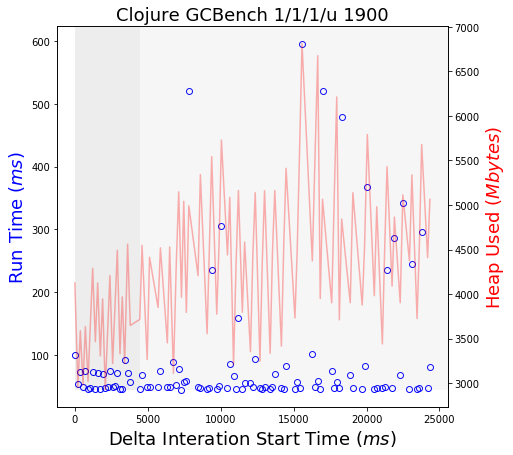

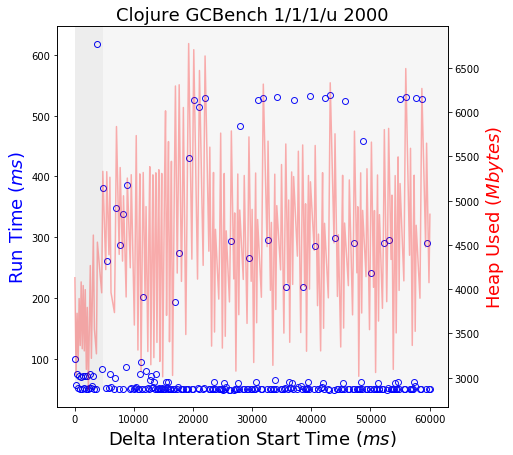

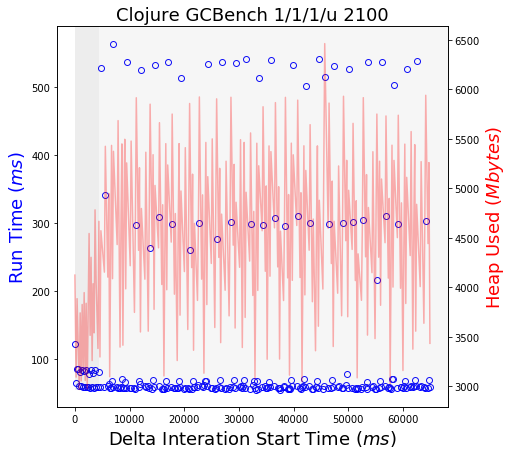

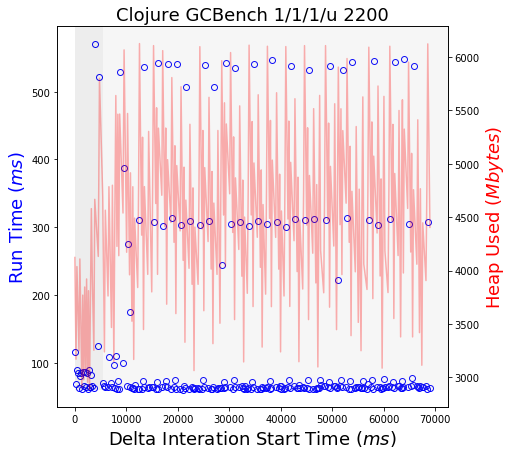

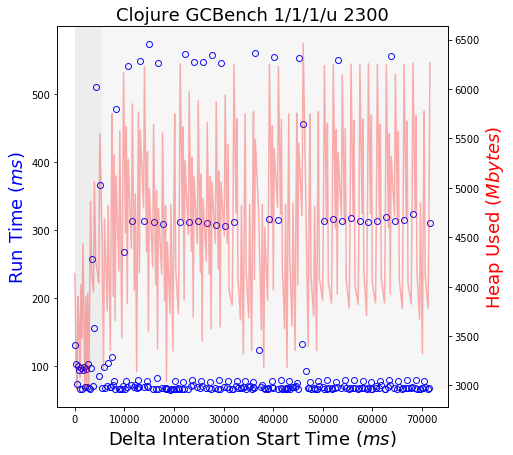

In [9]:
#gen_graph(name='clojure-1300', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
#         HEAPLABEL=False, CTLABEL=False)
#gen_graph(name='clojure-1400', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
#         HEAPLABEL=False, CTLABEL=False)
#gen_graph(name='clojure-1500', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
#         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-1600', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
#gen_graph(name='clojure-1700', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
#         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-1800', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-1900', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-2000', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-2100', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-2200', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)
gen_graph(name='clojure-2300', W=250, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400),
         HEAPLABEL=False, CTLABEL=False)

scala-37-ConcMarkSweepGC.txt
xs_  (250,) 0.0 325268.0
ys_  (250,) 299.0 438.0
hp   (250,) 5 279
xs_30  15797.0
scala-38-ConcMarkSweepGC.txt
xs_  (250,) 0.0 371715.0
ys_  (250,) 484.0 505.0
hp   (250,) 4 267
xs_30  17912.0
scala-39-ConcMarkSweepGC.txt
xs_  (250,) 0.0 448851.0
ys_  (250,) 785.0 873.0
hp   (250,) 7 276
xs_30  21567.0
scala-40-ConcMarkSweepGC.txt
xs_  (250,) 0.0 581154.0
ys_  (250,) 1235.0 1752.0
hp   (250,) 7 274
xs_30  27427.0


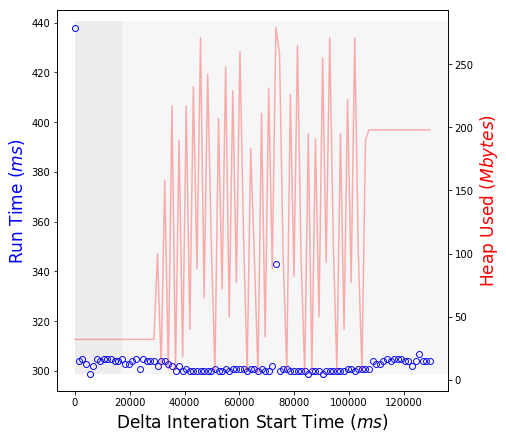

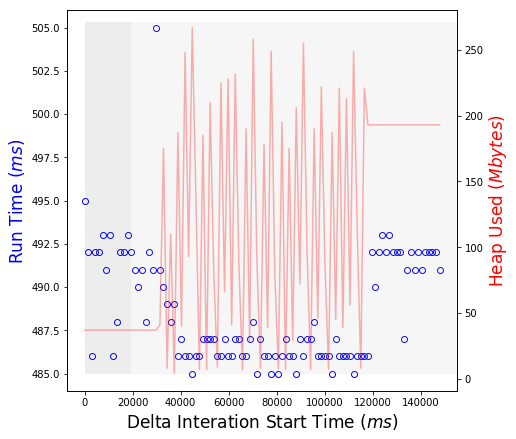

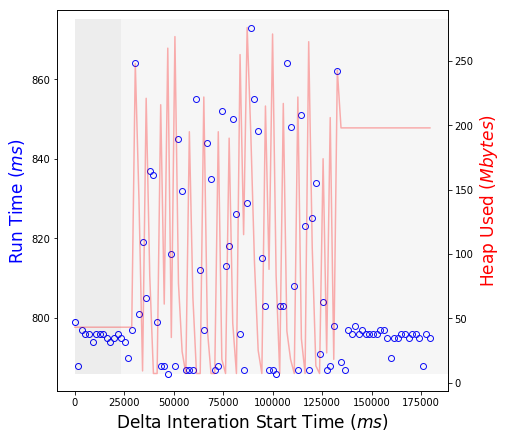

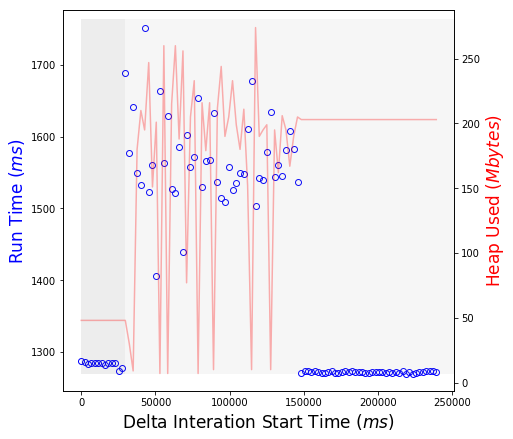

In [10]:
gen_graph(name='scala-37-ConcMarkSweepGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-38-ConcMarkSweepGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-39-ConcMarkSweepGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))
gen_graph(name='scala-40-ConcMarkSweepGC.txt', W=100, B=13, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, 
          XDIV=1, YDIV=1, CTLABEL=False, CTLO=(0,-900), HEAPLABEL=False, HEAPLO=(0,-400))

tight2-cloj-gcb
xs_  (500,) 0.0 926.437
ys_  (500,) 425.0 3722.0
hp   (500,) 4 67
xs_30  57.807


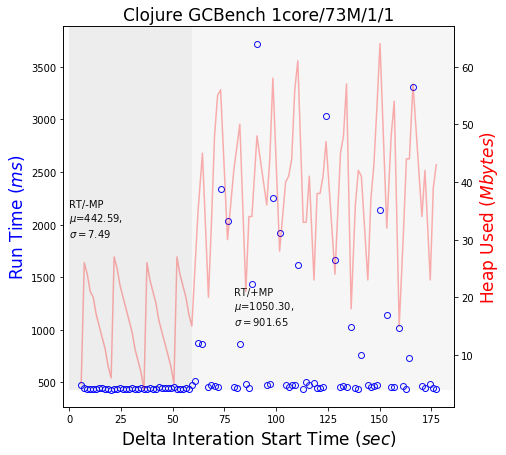

In [15]:
gen_graph(name='tight2-cloj-gcb', W=100, B=40, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,1000), HEAPLABEL=True, HEAPLO=(0,0))

20170711-cloj-p9-tight2
xs_  (500,) 0.0 1523.063
ys_  (500,) 762.0 3525.0
hp   (500,) 4 14
xs_30  56.413


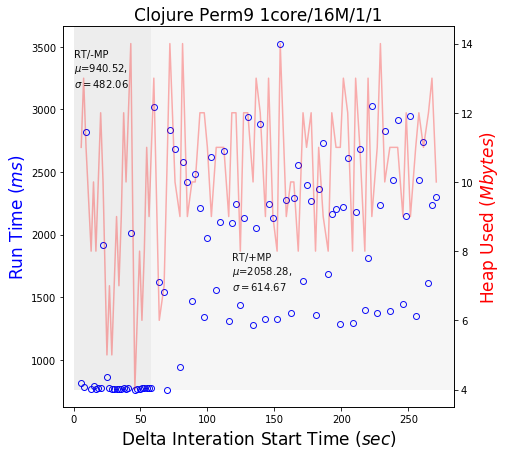

In [14]:
gen_graph(name='20170711-cloj-p9-tight2', W=100, B=30, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,1300), HEAPLABEL=True, HEAPLO=(0,-500))

20170725-haskell-gcb
xs_  (1100,) 0.0 1993.84172463
ys_  (1100,) 35.0561141968 1013.88478279
hp   (1100,) 0 382
xs_30  61.6283376217


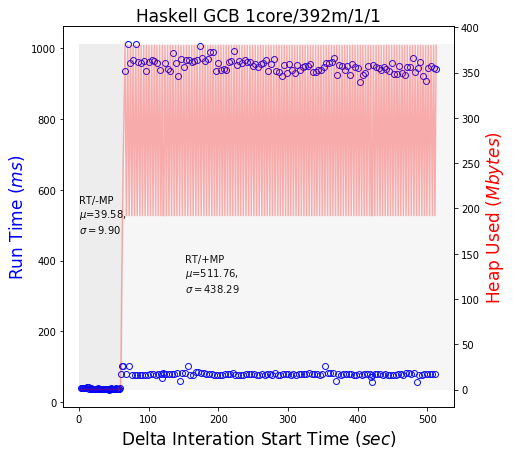

In [8]:
gen_graph(name='20170725-haskell-gcb', W=300, B=60, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1, YDIV=0.001, CTLABEL=True, CTLO=(0,400), HEAPLABEL=True, HEAPLO=(100,-200))

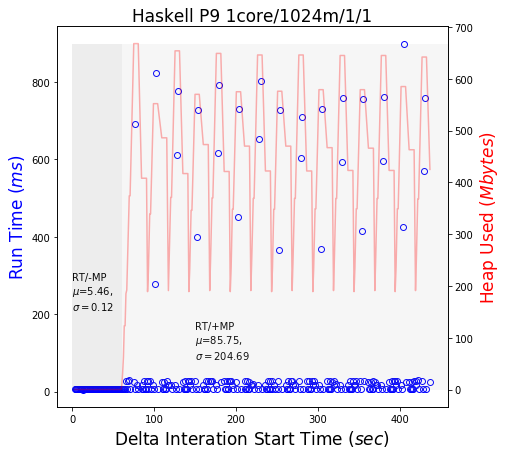

In [17]:
gen_graph(name='20170725-haskell-p9', W=300, B=60, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1, YDIV=0.001, CTLABEL=True, CTLO=(0,200), HEAPLABEL=True, HEAPLO=(100,-0.2))